In [8]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

In [9]:
# ================================================================
# Step 2: Define your parameters
# ================================================================
# Path to your processed data file
data_path = r'C:\Users\epoch_bpjmdqk\Documents\Code\data\processed\stock_and_macro.csv'

# Path to the saved model
model_path = r'C:\Users\epoch_bpjmdqk\Documents\Code\models\randomforest_w10_t0.005.pkl'

# Define the data preparation parameters that the model was trained on
target_ticker = 'WMT'
window = 10
threshold = 0.015

# Define the backtesting period split
backtest_start_date = '2021-01-01'

# NEW: Define real-world trading costs and starting balance
# A small percentage fee per trade
transaction_cost_per_trade = 0.001  # 0.1% transaction cost
# A small penalty on the entry price
slippage_factor = 0.0005 # 0.05% slippage

# Starting capital for the backtest
starting_balance = 10000.0

# This is the target percentage of your portfolio to allocate to the stock when
# the model predicts a price increase (1).
allocation_percentage = 0.50 # 50% allocation

In [10]:
# ================================================================
# Step 3: Load the data and the trained model
# ================================================================
def create_target_variable(df, ticker, window, threshold):
    """
    Creates a target variable based on the cumulative return over a specified window.
    """
    # Dynamically create the target return column name
    target_return_col_name = f'{ticker}_target_return_{window}D_{threshold}'
    df[target_return_col_name] = df[f'Close_{ticker}'].pct_change(periods=window).shift(-window)
    df[f'{ticker}_Target'] = (df[target_return_col_name] > threshold).astype(int)
    return df

try:
    # Load the processed data
    data = pd.read_csv(data_path, index_col='Date', parse_dates=True)
    
    # Load the trained model from the pickle file
    with open(model_path, 'rb') as file:
        best_model = pickle.load(file)
    
    print("✅ Successfully loaded data and the best model.")

except FileNotFoundError:
    print(f"Error: Could not find one of the files. Please check paths:")
    print(f"Data path: {data_path}")
    print(f"Model path: {model_path}")
    exit()

✅ Successfully loaded data and the best model.


In [11]:
# ================================================================
# Step 4: Data preparation for backtesting
# ================================================================
data_with_target = create_target_variable(data.copy(), target_ticker, window=window, threshold=threshold)

# Define column names
target_col_name = f'{target_ticker}_Target'
# Get the correct target return column name from the function
target_return_col_name = f'{target_ticker}_target_return_{window}D_{threshold}'


# Drop columns not used for training
columns_to_drop = [
    target_col_name,
    target_return_col_name,
    f'Open_{target_ticker}',
    f'High_{target_ticker}',
    f'Low_{target_ticker}',
    f'Close_{target_ticker}'
]
data_with_target.dropna(inplace=True)

# Split data into training and backtesting sets
X_backtest = data_with_target.loc[backtest_start_date:].drop(columns=columns_to_drop)
y_backtest = data_with_target.loc[backtest_start_date:][target_col_name]
backtest_data = data_with_target.loc[backtest_start_date:].copy()

# Get the list of features used in the model
features = X_backtest.columns

print(f"\n--- Backtesting on unseen data from {backtest_start_date} to {backtest_data.index[-1].strftime('%Y-%m-%d')} ---")



--- Backtesting on unseen data from 2021-01-01 to 2022-12-15 ---


In [12]:
# Make predictions on the backtesting data
backtest_predictions = best_model.predict(X_backtest)
backtest_predictions_df = pd.Series(backtest_predictions, index=X_backtest.index, name='Prediction')
backtest_data['Prediction'] = backtest_predictions_df

# --- Account Simulation ---
balance = starting_balance
shares_held = 0
account_history = []
buy_trades = 0
sell_trades = 0

# Count the number of signals for diagnostic purposes
buy_signals = (backtest_data['Prediction'] == 1).sum()
sell_signals = (backtest_data['Prediction'] == 0).sum()

for date, row in backtest_data.iterrows():
    # Get today's close price and model prediction
    current_price = row[f'Close_{target_ticker}']
    prediction = row['Prediction']

    # --- NEW CONTINUOUS ALLOCATION TRADING LOGIC ---
    current_account_value = balance + (shares_held * current_price)
    current_position_value = shares_held * current_price

    if prediction == 1:
        # If model predicts a rise, target is the defined allocation percentage
        target_position_value = current_account_value * allocation_percentage
    else:
        # If model predicts no rise, target is 0 (move to cash)
        target_position_value = 0

    # Execute trades to get to the target position
    if target_position_value > current_position_value:
        # We need to buy
        amount_to_buy = target_position_value - current_position_value
        shares_to_buy = amount_to_buy / (current_price * (1 + slippage_factor))
        
        # Only trade if we can buy at least one share
        if shares_to_buy >= 1:
            shares_bought = int(shares_to_buy)
            cost_of_trade = shares_bought * current_price * (1 + slippage_factor)
            
            # Check if we have enough balance to make the trade
            if balance >= cost_of_trade:
                balance -= cost_of_trade
                balance -= cost_of_trade * transaction_cost_per_trade
                shares_held += shares_bought
                buy_trades += 1
                
    elif target_position_value < current_position_value:
        # We need to sell
        amount_to_sell = current_position_value - target_position_value
        shares_to_sell = amount_to_sell / (current_price * (1 - slippage_factor))
        
        # Only trade if we can sell at least one share
        if shares_to_sell >= 1:
            shares_sold = int(shares_to_sell)
            
            # Make sure we don't try to sell more than we hold
            if shares_held >= shares_sold:
                proceeds = shares_sold * current_price * (1 - slippage_factor)
                balance += proceeds
                balance -= proceeds * transaction_cost_per_trade
                shares_held -= shares_sold
                sell_trades += 1

    # Record the current account value for plotting
    current_account_value = balance + (shares_held * current_price)
    account_history.append(current_account_value)

# Create a DataFrame for the account history
account_df = pd.DataFrame({
    'Balance': account_history
}, index=backtest_data.index)

In [13]:
# ================================================================
# Step 6: Create a buy-and-hold benchmark
# ================================================================
# Slice the raw data for the backtest period to ensure accuracy
buy_and_hold_data = data.loc[backtest_start_date:].copy()

# Buy as many shares as possible at the start
buy_and_hold_shares = int(starting_balance / buy_and_hold_data.iloc[0][f'Close_{target_ticker}'])
buy_and_hold_initial_cash = starting_balance - (buy_and_hold_shares * buy_and_hold_data.iloc[0][f'Close_{target_ticker}'])
# Calculate the daily balance by multiplying shares by the daily close price and adding initial cash
buy_and_hold_balance = buy_and_hold_data[f'Close_{target_ticker}'] * buy_and_hold_shares + buy_and_hold_initial_cash


--- Backtesting Results (with Real-World Costs & Continuous Allocation) ---
Starting Balance: $10000.00

--- Buy-and-Hold Diagnostic ---
Buy-and-Hold Start Date: 2021-01-04
Buy Price (Initial Price): $45.83
Buy-and-Hold End Date: 2022-12-30
Sell Price (Final Price): $45.77
Shares purchased: 218
Remaining initial cash: $8.11
Final Buy-and-Hold Balance: $9984.94
Buy-and-Hold Total Return: -0.15%

--- Strategy Results ---
Final Strategy Balance: $9573.29
Strategy Total Return: -4.27%
Strategy Annualized Return: -2.20%
Total Buy Trades: 52
Total Sell Trades: 42
Total Trades: 94

--- Diagnostic: Model Signals ---
Total Buy Signals (Prediction=1): 209
Total Sell Signals (Prediction=0): 284

--- Overall Performance ---
Buy-and-Hold Annualized Return: -0.08%

--- Top 10 Most Important Features ---
WMT_Volume_MA_20D       0.016778
DGS10                   0.016770
KO_BB_Middle20          0.014906
WMT_vs_KO_CloseRatio    0.013716
COST_Volume_MA_20D      0.012507
^GSPC_MACD_Hist         0.011986


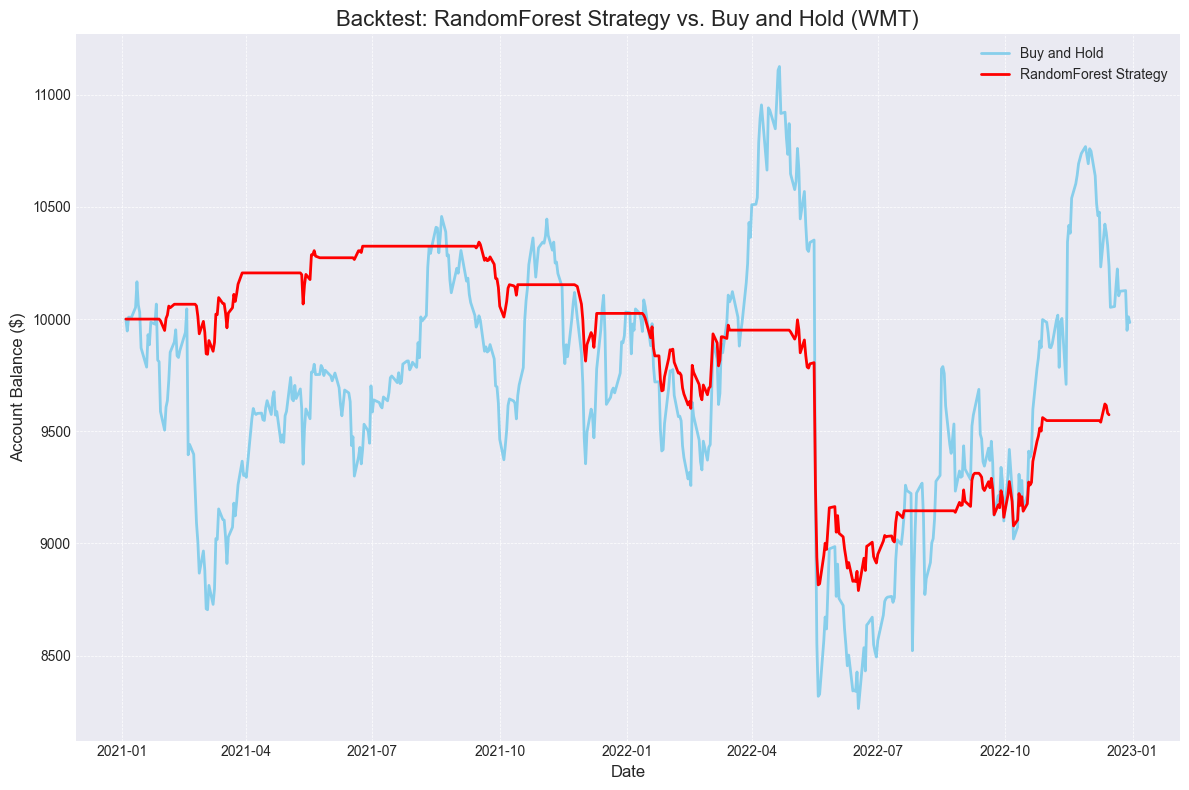

In [14]:
# ================================================================
# Step 7: Calculate and visualize backtesting performance
# ================================================================
# Calculate final metrics
total_strategy_return = (account_df['Balance'].iloc[-1] / starting_balance) - 1
total_buy_and_hold_return = (buy_and_hold_balance.iloc[-1] / starting_balance) - 1
annualized_strategy_return = (1 + total_strategy_return)**(252 / len(account_df)) - 1
annualized_buy_and_hold_return = (1 + total_buy_and_hold_return)**(252 / len(account_df)) - 1


# Display final results
print("\n--- Backtesting Results (with Real-World Costs & Continuous Allocation) ---")
print(f"Starting Balance: ${starting_balance:.2f}")

print("\n--- Buy-and-Hold Diagnostic ---")
print(f"Buy-and-Hold Start Date: {buy_and_hold_data.index[0].strftime('%Y-%m-%d')}")
print(f"Buy Price (Initial Price): ${buy_and_hold_data.iloc[0][f'Close_{target_ticker}']:.2f}")
print(f"Buy-and-Hold End Date: {buy_and_hold_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Sell Price (Final Price): ${buy_and_hold_data.iloc[-1][f'Close_{target_ticker}']:.2f}")
print(f"Shares purchased: {buy_and_hold_shares}")
print(f"Remaining initial cash: ${buy_and_hold_initial_cash:.2f}")
print(f"Final Buy-and-Hold Balance: ${buy_and_hold_balance.iloc[-1]:.2f}")
print(f"Buy-and-Hold Total Return: {total_buy_and_hold_return:.2%}")

print("\n--- Strategy Results ---")
print(f"Final Strategy Balance: ${account_df['Balance'].iloc[-1]:.2f}")
print(f"Strategy Total Return: {total_strategy_return:.2%}")
print(f"Strategy Annualized Return: {annualized_strategy_return:.2%}")
print(f"Total Buy Trades: {buy_trades}")
print(f"Total Sell Trades: {sell_trades}")
print(f"Total Trades: {buy_trades + sell_trades}")

print("\n--- Diagnostic: Model Signals ---")
print(f"Total Buy Signals (Prediction=1): {buy_signals}")
print(f"Total Sell Signals (Prediction=0): {sell_signals}")

print("\n--- Overall Performance ---")
print(f"Buy-and-Hold Annualized Return: {annualized_buy_and_hold_return:.2%}")


# --- Extract and display top features ---
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=features)
    top_features = importances.nlargest(10)
    print("\n--- Top 10 Most Important Features ---")
    print(top_features)

# Create the plot
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-v0_8-darkgrid')
plt.plot(buy_and_hold_balance, label='Buy and Hold', color='skyblue', linewidth=2)
plt.plot(account_df['Balance'], label='RandomForest Strategy', color='red', linewidth=2)
plt.title(f'Backtest: RandomForest Strategy vs. Buy and Hold ({target_ticker})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Account Balance ($)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
